# Kaggle Home Credit Default Risk - All files

In [1]:
import os
import sys
import numpy as np
import pandas as pd

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

from scipy.stats import skew, kurtosis, iqr

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# add by me
from datetime import datetime

import gc

from utils import missing_ratio, memory_reduce

In [ ]:
app_train = pd.read_csv('../data/application_train.csv')
print('application_train data shape: ', app_train.shape)
app_test = pd.read_csv('../data/application_test.csv')
print('Testing data shape: ', app_test.shape)

In [ ]:
credit_card_balance[(credit_card_balance['SK_ID_PREV'] == 1330831) 
                    & (credit_card_balance['SK_ID_CURR'] == 151639) 
                    & (credit_card_balance['AMT_BALANCE'] > 0)]['AMT_BALANCE'].mean()

### New Merge Method of other files

In [2]:
credit_card_balance = pd.read_csv('../data/credit_card_balance.csv')
print('\t- credit_card_balance data shape: ', credit_card_balance.shape)

	- credit_card_balance data shape:  (3840312, 23)


In [4]:
pos_cash_balance = pd.read_csv('../data/POS_CASH_balance.csv')
print('\t- POS_CASH_balance data shape: ', pos_cash_balance.shape)

	- POS_CASH_balance data shape:  (10001358, 8)


In [9]:
%%time

keys = ['MONTHS_BALANCE', 'NAME_CONTRACT_STATUS', 'SK_DPD', 'SK_DPD_DEF', 'SK_ID_CURR', 'SK_ID_PREV']

credit_card_col = ['MONTHS_BALANCE', 'NAME_CONTRACT_STATUS', 'SK_DPD', 'SK_DPD_DEF', 'SK_ID_CURR', 'SK_ID_PREV', 'CNT_INSTALMENT_MATURE_CUM']
installment_col = ['CNT_INSTALMENT', 'CNT_INSTALMENT_FUTURE', 'CNT_INSTALMENT_MATURE_CUM']

ccb_pcb = credit_card_balance.merge(pos_cash_balance, on=keys, how='outer')

# Clean up memory
gc.enable()
del credit_card_balance, pos_cash_balance
gc.collect()

print(ccb_pcb.shape)

(13841670, 25)
Wall time: 28.6 s


In [3]:
ccb_pcb['AMT_PAYMENT_CURRENT'].fillna(0, inplace=True)
ccb_pcb['CNT_DRAWINGS_POS_CURRENT'].fillna(0, inplace=True)
ccb_pcb['CNT_DRAWINGS_OTHER_CURRENT'].fillna(0, inplace=True)
ccb_pcb['CNT_DRAWINGS_ATM_CURRENT'].fillna(0, inplace=True)
ccb_pcb['AMT_DRAWINGS_POS_CURRENT'].fillna(0, inplace=True)
ccb_pcb['AMT_DRAWINGS_OTHER_CURRENT'].fillna(0, inplace=True)
ccb_pcb['AMT_DRAWINGS_ATM_CURRENT'].fillna(0, inplace=True)
ccb_pcb['CNT_INSTALMENT_MATURE_CUM'].fillna(0, inplace=True)
ccb_pcb['AMT_INST_MIN_REGULARITY'].fillna(0, inplace=True)
ccb_pcb['CNT_INSTALMENT'].fillna(0, inplace=True)
ccb_pcb['CNT_INSTALMENT_FUTURE'].fillna(0, inplace=True)

###### Step 2

In [9]:
previous_application = pd.read_csv('../data/previous_application.csv')
print('previous_application data shape: ', previous_application.shape)

previous_application data shape:  (1670214, 37)


In [9]:
%%time

print(ccb_pcb.shape)
print(previous_application.shape)
_keys = ['NAME_CONTRACT_STATUS', 'SK_ID_CURR', 'SK_ID_PREV']

ccb_pcb_pa = ccb_pcb.merge(previous_application, on=_keys, how='outer')

# Clean up memory
gc.enable()
del previous_application, ccb_pcb
gc.collect()

ccb_pcb_pa = memory_reduce(ccb_pcb_pa)

print(ccb_pcb_pa.shape)

(13841670, 25)
(1670214, 37)
(15507231, 59)
Wall time: 1min 25s


###### Step 3

In [15]:
installments_payments = pd.read_csv('../data/installments_payments.csv')
print('installments_payments data shape: ', installments_payments.shape)

installments_payments data shape:  (13605401, 8)


In [ ]:
%%time

print(ccb_pcb_pa.shape)
print(installments_payments.shape)

installments_payments = memory_reduce(installments_payments)

_keys_ = ['SK_ID_CURR', 'SK_ID_PREV']

ccb_pcb_pa_ip = ccb_pcb_pa.merge(installments_payments, on=_keys_, how='outer')

# Clean up memory
gc.enable()
del installments_payments, ccb_pcb_pa
gc.collect()

print(ccb_pcb_pa_ip.shape)

###### Test Merge with chunck

In [5]:
keys = ['MONTHS_BALANCE', 'NAME_CONTRACT_STATUS', 'SK_DPD', 'SK_DPD_DEF', 'SK_ID_CURR', 'SK_ID_PREV']
print(pos_cash_balance[keys].drop_duplicates().shape)
print(credit_card_balance[keys].drop_duplicates().shape)

(10001358, 6)
(3840312, 6)


In [16]:
%%time

# df1 = pd.read_csv("yourdata.csv")
# df2 = pd.read_csv("yourdata2.csv")
# df2_key = df2.Colname2

# creating a empty bucket to save result
df_result = pd.DataFrame(columns=(credit_card_balance.columns.append(pos_cash_balance.columns)).unique())
df_result.to_csv('../data_processed/tmp_ccb_pcb_merged.csv', index_label=False)

# save data which only appear in df1 # sorry I was doing left join here. no need to run below two line.
# df_result = df1[df1.Colname1.isin(df2.Colname2)!=True]
# df_result.to_csv("df3.csv",index_label=False, mode="a")

# deleting df2 to save memory
del(pos_cash_balance)

def preprocess(x):
#     df2=pd.merge(df1,x, left_on = "Colname1", right_on = "Colname2")
    df2 = credit_card_balance.merge(x, on=keys, how='outer')
    df2.to_csv('../data_processed/tmp_ccb_pcb_merged.csv', mode="a", header=False, index=False)

reader = pd.read_csv('../data/POS_CASH_balance.csv', chunksize=1000000) # chunksize depends with you colsize

[preprocess(r) for r in reader]

Wall time: 19min 1s


In [ ]:
sizetest = pd.read_csv('../data_processed/tmp_ccb_pcb_merged.csv', chunksize=1000000)
sizetest.drop_duplicates().shape

###### Test new merge

In [2]:
%%time

credit_card_balance = pd.read_csv('../data/credit_card_balance.csv')
print('\t- credit_card_balance data shape: ', credit_card_balance.shape)
pos_cash_balance = pd.read_csv('../data/POS_CASH_balance.csv')
print('\t- POS_CASH_balance data shape: ', pos_cash_balance.shape)

	- credit_card_balance data shape:  (3840312, 23)
	- POS_CASH_balance data shape:  (10001358, 8)
Wall time: 22.8 s


In [3]:
%%time

keys = ['MONTHS_BALANCE', 'NAME_CONTRACT_STATUS', 'SK_DPD', 'SK_DPD_DEF', 'SK_ID_CURR', 'SK_ID_PREV']
tt = pd.concat([pos_cash_balance[keys].drop_duplicates(), credit_card_balance[keys].drop_duplicates()])

print(tt.shape)
print(tt.drop_duplicates().shape)
tt = tt.merge(pos_cash_balance, on=keys, how='left')
print(tt.shape)
tt = tt.merge(credit_card_balance, on=keys, how='left')
print(tt.shape)

(13841670, 6)
(13841670, 6)
(13841670, 8)
(13841670, 25)
Wall time: 1min 14s


In [4]:
%%time

# Clean up memory
gc.enable()
del credit_card_balance, pos_cash_balance
gc.collect()

tt = memory_reduce(tt)

	> Launch Memory Reduction
		- Initial size 2745.69 MB
		- There are 1 columns that cannot be reduced
		- There are 24 columns reduced
		- Final size 1201.24 MB
	> End of Memory Reduction
Wall time: 45.8 s


In [5]:
%%time

previous_application = pd.read_csv('../data/previous_application.csv')
print('previous_application data shape: ', previous_application.shape)

previous_application data shape:  (1670214, 37)
Wall time: 10.2 s


In [6]:
%%time

previous_application = memory_reduce(previous_application)
print(previous_application.shape)

_keys = ['NAME_CONTRACT_STATUS', 'SK_ID_CURR', 'SK_ID_PREV']
jj = pd.concat([tt[_keys].drop_duplicates(), previous_application[_keys].drop_duplicates()])
print(jj.shape)
jj.drop_duplicates(inplace=True)
print(jj.shape)
jj = jj.merge(tt, on=_keys, how='left')
print(jj.shape)
jj = jj.merge(previous_application, on=_keys, how='left')
print(jj.shape)
jj.drop_duplicates(inplace=True)
print(jj.shape)

	> Launch Memory Reduction
		- Initial size 471.48 MB
		- There are 16 columns that cannot be reduced
		- There are 21 columns reduced
		- Final size 309.01 MB
	> End of Memory Reduction
(1670214, 37)
(3512865, 3)
(3508212, 3)
(15507231, 25)
(15507231, 59)
(15507231, 59)
Wall time: 5min 51s


In [7]:
%%time

# Clean up memory
gc.enable()
del previous_application, tt
gc.collect()

jj = memory_reduce(jj)

	> Launch Memory Reduction
		- Initial size 4614.12 MB
		- There are 16 columns that cannot be reduced
		- There are 43 columns reduced
		- Final size 4022.57 MB
	> End of Memory Reduction
Wall time: 1min 9s


In [2]:
%%time

installments_payments = pd.read_csv('../data/installments_payments.csv')
print('installments_payments data shape: ', installments_payments.shape)

NameError: name 'pd' is not defined

In [1]:
%%time

print(installments_payments.shape)
installments_payments = memory_reduce(installments_payments)

_keys_ = ['SK_ID_CURR', 'SK_ID_PREV']
qq = pd.concat([jj[_keys_].drop_duplicates(), installments_payments[_keys_].drop_duplicates()])
print(qq.shape)
qq.drop_duplicates(inplace=True)
print(qq.shape)
qq = qq.merge(jj, on=_keys_, how='left')
print(qq.shape)
qq.drop_duplicates(inplace=True)
print(qq.shape)
qq = memory_reduce(qq)
qq = qq.merge(installments_payments, on=_keys_, how='left')
print(qq.shape)

NameError: name 'installments_payments' is not defined

In [ ]:
%%time

# Clean up memory
gc.enable()
del installments_payments, jj
gc.collect()

qq = memory_reduce(qq)

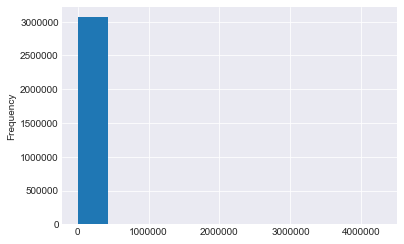

In [50]:
credit_card_balance['AMT_PAYMENT_CURRENT'].plot.hist();

In [51]:
credit_card_balance['AMT_PAYMENT_CURRENT'].describe()

count    3.072324e+06
mean     1.028054e+04
std      3.607808e+04
min      0.000000e+00
25%      1.523700e+02
50%      2.702700e+03
75%      9.000000e+03
max      4.289207e+06
Name: AMT_PAYMENT_CURRENT, dtype: float64

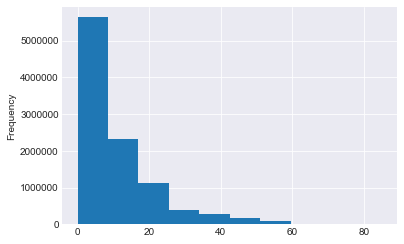

In [47]:
pos_cash_balance['CNT_INSTALMENT_FUTURE'].plot.hist();

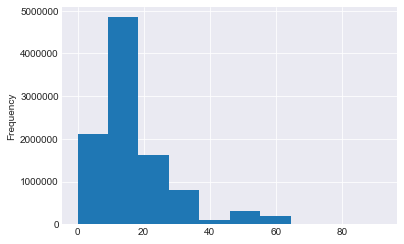

In [48]:
pos_cash_balance['CNT_INSTALMENT'].plot.hist();

In [49]:
pos_cash_balance['CNT_INSTALMENT'].describe()

count    1.000136e+07
mean     1.704510e+01
std      1.201106e+01
min      0.000000e+00
25%      1.000000e+01
50%      1.200000e+01
75%      2.400000e+01
max      9.200000e+01
Name: CNT_INSTALMENT, dtype: float64

,Missing Ratio
AMT_RECEIVABLE_PRINCIPAL,72.255429
AMT_PAYMENT_TOTAL_CURRENT,72.255429
AMT_CREDIT_LIMIT_ACTUAL,72.255429
AMT_DRAWINGS_ATM_CURRENT,72.255429
AMT_DRAWINGS_CURRENT,72.255429
AMT_DRAWINGS_OTHER_CURRENT,72.255429
AMT_DRAWINGS_POS_CURRENT,72.255429
AMT_INST_MIN_REGULARITY,72.255429
AMT_PAYMENT_CURRENT,72.255429
AMT_BALANCE,72.255429


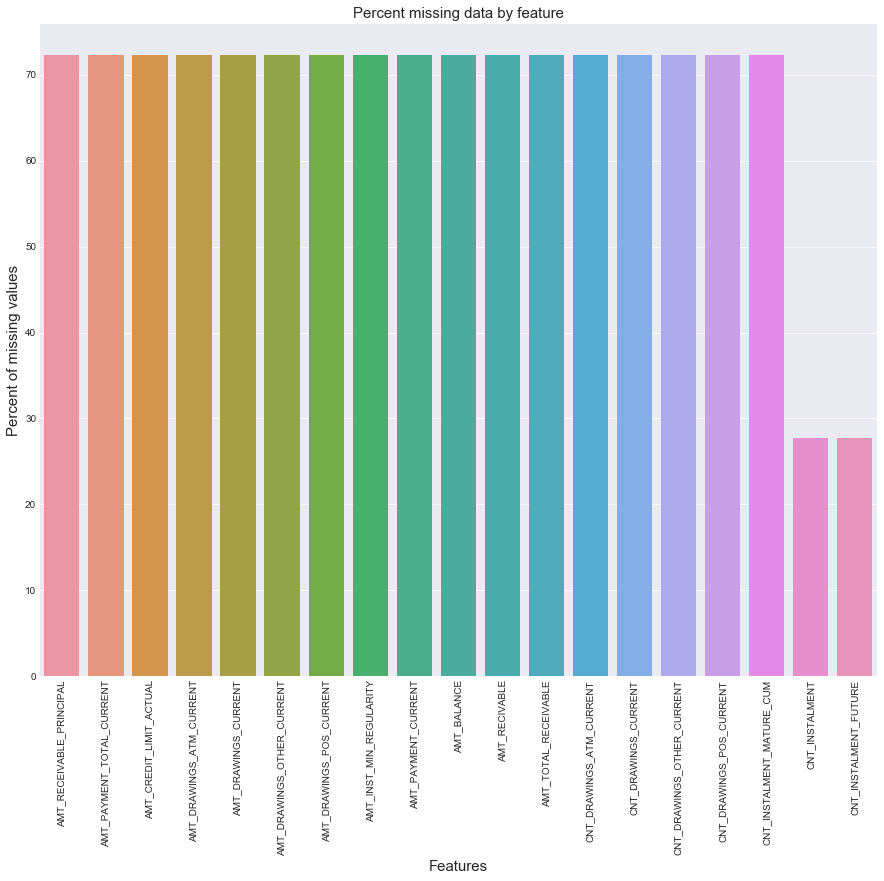

In [7]:
missing_ratio(ccb_pcb)

In [17]:
missing_ratio(ccb_pcb_pa, n=60, plot=False)

,Missing Ratio
NAME_TYPE_SUITE,94.519092
PRODUCT_COMBINATION,89.230005
NAME_YIELD_GROUP,89.227774
NAME_SELLER_INDUSTRY,89.227774
CHANNEL_TYPE,89.227774
NAME_PRODUCT_TYPE,89.227774
NAME_PORTFOLIO,89.227774
NAME_GOODS_CATEGORY,89.227774
NAME_CLIENT_TYPE,89.227774
CODE_REJECT_REASON,89.227774


In [ ]:
ccb_pcb_pa_ip.head()

In [ ]:
print(previous_application.shape)
preapp_col = []
for col in previous_application.columns:
    if 'DAY' in col:
        preapp_col.append(col)
        
preapp_col

In [ ]:
previous_application[preapp_col].head()

In [ ]:
print(credit_card_balance.shape)
print(len(amt_col))
print(len(keys))

In [ ]:
amt_col = []
for col in credit_card_balance.columns:
    if 'AMT' in col:
        amt_col.append(col)
        
amt_col

In [ ]:
credit_card_balance[(t['SK_ID_CURR'] == 371185) 
                    & (t['SK_ID_PREV'] == 1740877)].sort_values(['SK_ID_CURR', 'SK_ID_PREV', 'MONTHS_BALANCE'])[amt_col]

In [ ]:
_balance_col = []
for col in pos_cash_balance.columns:
    if 'AMT' in col:
        _balance_col.append(col)
        
_balance_col

In [ ]:
t[(t['SK_ID_CURR'] == 397406) & (t['SK_ID_PREV'] == 2492206)].sort_values(['SK_ID_CURR', 'SK_ID_PREV', 'MONTHS_BALANCE'])

In [ ]:
t['AMT_BALANCE'].describe()

In [ ]:
t[t['AMT_BALANCE'] > 0]['AMT_BALANCE'].plot.hist();

In [ ]:
t[t['AMT_BALANCE'] != -420250.185]['AMT_BALANCE'].plot.box()

In [ ]:
t[t.duplicated(keys)]